## Рекомендательная система

### Цель проекта

Разработать рекомендательную систему. Сервис будет на основании признаков пользователей и постов, а также взаимодействия между ними, возвращать по запросу для юзера N постов, которые пользователю покажут в его ленте соцсети.

### Задачи

1. Загрузить данные из БД.
2. Обработать данные: преобразовать форматы, поработать с пропущенными значениями, нормализовать данные.
3. Провести фича-инжиниринг, создавая признаки для модели на основе доступных данных.
4. Выбрать и обучить модель машинного обучения, используя библиотеки Python.
5. Проверить качество модели с использованием метрик и на кросс-валидации.
6. Загрузить на сервер подготовленные фичи и обученную моделью.
7. Написать сервис на FastAPI со следующим алгоритмом работы:
    - запуск сервиса:
        * загрузка предобученной ранее модели
        * загрузка подготовленных фичей
    - endpoint:
        * фильтрация фичей пользователя по id
        * загрузка фичей постов для юзера
        * объединим фичи юзеров и постов через feed_action
        * выделим фичи из даты
        * определим для юзера вероятности лайка постов
        * уберем лайкнутые ранее посты
        * рекомендуем топ постов

### Описание данных

Таблица `user_data`

Cодержит информацию о всех пользователях соц.сети

- `age`	- Возраст пользователя
- `city`	- Город пользователя
- `country` -	Страна пользователя
- `exp_group` -	Экспериментальная группа: некоторая зашифрованная категория
- `gender`	- Пол пользователя
- `id`	- Уникальный идентификатор пользователя
- `os`	- Операционная система устройства, с которого происходит пользование соц.сетью
- `source`	- Пришел ли пользователь в приложение с органического трафика или с рекламы

Таблица `post_text_df`

Содержит информацию о постах и уникальный ID каждой единицы с соответствующим ей текстом и топиком

- `id`	- Уникальный идентификатор поста
- `text` - Текстовое содержание поста
- `topic` - Основная тематика

Таблица `feed_data`

Содержит историю о просмотренных постах для каждого юзера

- `timestamp` - Время, когда был произведен просмотр
- `user_id` - id пользователя, который совершил просмотр
- `post_id`	- id просмотренного поста
- `action`	- Тип действия: просмотр или лайк
- `target`	- 1 у просмотров, если почти сразу после просмотра был совершен лайк, иначе 0. У действий like пропущенное значение

## Параметры и подключаемые библиотеки

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
import os
import re
import string
import pickle

import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from dotenv import load_dotenv
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sqlalchemy import create_engine

## Подключение к базе и основные таблицы
### users

In [44]:
# Создадим подключение к базе данных

load_dotenv()
conn_url = os.environ.get("POSTGRES_URL")

In [45]:
# Посмотрим на данные о пользователях

user_data = pd.read_sql(
    "SELECT * FROM public.user_data",
    conn_url
)
user_data

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [46]:
# Проверим на пропущенные значения

user_data.isna().any()

user_id      False
gender       False
age          False
country      False
city         False
exp_group    False
os           False
source       False
dtype: bool

In [47]:
# Запросим количество просмотров по топикам для каждого юзера

user_view_by_topic = pd.read_sql(
    """
    SELECT public.feed_data.user_id, public.post_text_df.topic, COUNT(public.feed_data.action)
    FROM public.feed_data
    JOIN public.post_text_df ON public.feed_data.post_id=public.post_text_df.post_id
    WHERE public.feed_data.action='view'
    GROUP BY public.feed_data.user_id, public.post_text_df.topic;
    """,
    conn_url
)
user_view_by_topic.head()

,user_id,topic,count
0,200,business,28
1,200,covid,93
2,200,entertainment,14
3,200,movie,88
4,200,politics,58


In [48]:
# Развернем таблицу колонками по топикам

user_view_by_topic = user_view_by_topic.pivot_table(index="user_id",
                                                    columns="topic",
                                                    values="count")
user_view_by_topic.head(3)

topic,business,covid,entertainment,movie,politics,sport,tech
user_id,,,,,,,
200,28.0,93.0,14.0,88.0,58.0,64.0,13.0
201,29.0,172.0,33.0,269.0,72.0,86.0,29.0
202,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [49]:
# Уберем topic и user_id из названия колонок

user_view_by_topic.columns.name = None
user_view_by_topic.reset_index(inplace=True)
user_view_by_topic.head(3)

,user_id,business,covid,entertainment,movie,politics,sport,tech
0,200,28.0,93.0,14.0,88.0,58.0,64.0,13.0
1,201,29.0,172.0,33.0,269.0,72.0,86.0,29.0
2,202,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [50]:
# Заполним пустые значения нулями и проверим на пустые значения

user_view_by_topic.fillna(0, inplace=True)
user_view_by_topic.isna().sum()

user_id          0
business         0
covid            0
entertainment    0
movie            0
politics         0
sport            0
tech             0
dtype: int64

In [51]:
# Добавим ко всем пользователям колонки с просмотрами по топикам

user_data = pd.merge(user_data, user_view_by_topic, on="user_id", how="left")
user_data.head(3)

,user_id,gender,age,country,city,exp_group,os,source,business,covid,entertainment,movie,politics,sport,tech
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,14.0,88.0,58.0,64.0,13.0
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,33.0,269.0,72.0,86.0,29.0
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [52]:
# Сгенерируем доп фичи через кластеризацию юзеров

user_df = user_data.copy()
user_df.head()

,user_id,gender,age,country,city,exp_group,os,source,business,covid,entertainment,movie,politics,sport,tech
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,14.0,88.0,58.0,64.0,13.0
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,33.0,269.0,72.0,86.0,29.0
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,27.0,276.0,59.0,77.0,21.0
3,203,0,18,Russia,Moscow,1,iOS,ads,19.0,71.0,11.0,137.0,25.0,49.0,9.0
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,8.0,31.0,5.0,64.0,10.0,17.0,3.0


In [53]:
# Преобразуем exp_forup в категориальный признак и установим индекс на user_id

user_df.exp_group = user_df.exp_group.astype("object")
user_df.set_index("user_id", inplace=True)
user_df.head(3)

,gender,age,country,city,exp_group,os,source,business,covid,entertainment,movie,politics,sport,tech
user_id,,,,,,,,,,,,,,
200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,14.0,88.0,58.0,64.0,13.0
201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,33.0,269.0,72.0,86.0,29.0
202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [54]:
# Применим трансформер для преобразования фичей

user_obj_cols = list(user_df.select_dtypes(include='object').columns)
user_num_cols = list(user_df.select_dtypes(exclude='object').columns)

# Сохраним индексы этих колонок

user_obj_cols_idx = [list(user_df.columns).index(col) for col in user_obj_cols]
user_num_cols_idx = [list(user_df.columns).index(col) for col in user_num_cols]

t_users = [
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), user_obj_cols_idx),
    ('std', StandardScaler(), user_num_cols_idx)
]

In [55]:
#%%script false --no-raise-error

# Подберем оптимальное числло кластеров

distortion = []
K = range(1, 20) 

for k in K:
    user_pipe = Pipeline([("transform", ColumnTransformer(t_users)),
                          
                          ("kmeans", KMeans(n_clusters=k, random_state=0))])
    
    user_pipe.fit(user_df)
    distortion.append(user_pipe[1].inertia_)

In [56]:
%%script false --no-raise-error

fig = plt.figure()
fig.set_size_inches(16, 10)
plt.plot(K, distortion, "s-")
plt.xticks
plt.show()

Couldn't find program: 'false'


In [57]:
# Разделим юзеров по 8 кластерам и вычислим межкластерное расстояние, которое используем как фичи

user_pipe = Pipeline([("transform", ColumnTransformer(t_users)),

                      ("kmeans", KMeans(n_clusters=8, random_state=0))])

user_pipe.fit(user_df)

user_kmeans = user_pipe.transform(user_df)

# В качестве дополнительных признаков будем использовать расстояния до центров кластеров

user_kmeans_cols = [
    f"user_dist_to_{i + 1}_cluster" for i in range(user_kmeans.shape[1])]

user_kmeans = pd.DataFrame(user_kmeans, columns=user_kmeans_cols)
user_kmeans['user_num_cluster'] = user_pipe[1].labels_

user_kmeans.head(3)

,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
0,3.017298,3.578527,2.979593,2.221977,3.635041,3.928811,3.857473,4.662269,3
1,3.889771,6.056264,6.410042,4.467372,2.955178,3.267942,2.681371,3.399628,6
2,3.697253,5.540520,5.193849,3.193716,4.013128,4.113622,1.987895,3.736802,6


In [58]:
# Присоединим кластеры

user_data = pd.concat((user_data, user_kmeans), axis=1)

# переведем exp_group в категориальный признак
user_df.exp_group = user_df.exp_group.astype("object")

In [59]:
# Итоговая таблица по юзерам
user_data.head(3)

,user_id,gender,age,country,city,exp_group,os,source,business,covid,...,tech,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,...,13.0,3.017298,3.578527,2.979593,2.221977,3.635041,3.928811,3.857473,4.662269,3
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,...,29.0,3.889771,6.056264,6.410042,4.467372,2.955178,3.267942,2.681371,3.399628,6
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,...,21.0,3.697253,5.540520,5.193849,3.193716,4.013128,4.113622,1.987895,3.736802,6


In [60]:
user_data.isna().any().sum()

0

### posts

In [61]:
# Данные о постах

post_text_df = pd.read_sql(
    "SELECT * FROM public.post_text_df",
    conn_url
)
post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [62]:
# Трансформируем текст при помощи tfidf с предварительной обработкой

nltk.download("wordnet")

wnl = WordNetLemmatizer()


def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


vectorizer = TfidfVectorizer(
    stop_words="english",
    preprocessor=preprocessing
)
vect = vectorizer.fit_transform(post_text_df["text"]).toarray()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
# Развернем таблицу со словарем

vect_vocab = pd.DataFrame(
    vect,
    index=post_text_df.post_id,
    columns=vectorizer.get_feature_names_out()
)
vect_vocab.head(3)

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Генерим фичи на основе TfIdf

post_text_df['tfidf_sum'] = vect_vocab.sum(axis=1).reset_index()[0]
post_text_df['tfidf_mean'] = vect_vocab.mean(axis=1).reset_index()[0]
post_text_df['tfidf_max'] = vect_vocab.max(axis=1).reset_index()[0]

post_text_df.head(3)

,post_id,text,topic,tfidf_sum,tfidf_mean,tfidf_max
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.000190,0.495805
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.000258,0.308003
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.000276,0.261799


In [65]:
# Разделим на 16 кластеров тем самым сократим количество фичей

kmeans_posts = KMeans(n_clusters=16, random_state=0).fit(vect_vocab)

post_kmeans = kmeans_posts.transform(vect_vocab)

post_kmeans_cols = [
    f"post_dist_to_{i + 1}_cluster" for i in range(post_kmeans.shape[1])]

post_kmeans = pd.DataFrame(post_kmeans, columns=post_kmeans_cols)
post_kmeans['post_num_cluster'] = kmeans_posts.labels_
post_kmeans.head(3)

,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,post_dist_to_5_cluster,post_dist_to_6_cluster,post_dist_to_7_cluster,post_dist_to_8_cluster,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster
0,1.041581,1.017668,1.019208,1.000911,1.031834,1.009951,1.041794,1.036095,1.019183,1.006183,0.983297,1.004058,1.009302,0.919366,1.011768,1.030109,13
1,1.037858,1.013259,1.015774,0.996825,1.028048,1.010530,0.992664,1.033190,1.014563,1.003411,0.967705,0.999901,1.007325,0.989098,1.011587,1.028142,10
2,1.040713,1.011287,1.024541,0.997860,1.027201,1.010509,1.054104,1.035145,1.015846,1.005088,0.978229,1.006527,1.006882,0.950109,1.019272,1.027924,13


In [66]:
# Присоединим межкластерные расстояния к постам

post_text_df = pd.concat((post_text_df, post_kmeans), axis=1)

post_text_df.head(5)

,post_id,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,...,post_dist_to_8_cluster,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.000190,0.495805,1.041581,1.017668,1.019208,1.000911,...,1.036095,1.019183,1.006183,0.983297,1.004058,1.009302,0.919366,1.011768,1.030109,13
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.000258,0.308003,1.037858,1.013259,1.015774,0.996825,...,1.033190,1.014563,1.003411,0.967705,0.999901,1.007325,0.989098,1.011587,1.028142,10
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.000276,0.261799,1.040713,1.011287,1.024541,0.997860,...,1.035145,1.015846,1.005088,0.978229,1.006527,1.006882,0.950109,1.019272,1.027924,13
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.000144,0.537713,1.041159,1.017468,1.029216,1.002180,...,1.035985,1.020306,1.006496,0.977505,1.010382,1.009777,0.992911,1.022562,1.023690,10
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.000138,0.420251,1.044158,1.021138,1.031516,1.003333,...,1.038888,1.023036,1.008690,0.991778,1.020382,1.011292,1.025277,1.028433,1.033378,10


In [67]:
# Добавим количество лайков по постам

post_view_count = pd.read_sql(
    """
    SELECT public.feed_data.post_id, COUNT(public.feed_data.action) AS view_sum 
    FROM public.feed_data
    WHERE public.feed_data.action='view'
    GROUP BY public.feed_data.post_id;
    """,
    conn_url
)

post_text_df = pd.merge(post_text_df, post_view_count,
                        on="post_id", how="left")
post_text_df.head(3)

,post_id,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,...,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster,view_sum
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.000190,0.495805,1.041581,1.017668,1.019208,1.000911,...,1.019183,1.006183,0.983297,1.004058,1.009302,0.919366,1.011768,1.030109,13,8508.0
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.000258,0.308003,1.037858,1.013259,1.015774,0.996825,...,1.014563,1.003411,0.967705,0.999901,1.007325,0.989098,1.011587,1.028142,10,7495.0
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.000276,0.261799,1.040713,1.011287,1.024541,0.997860,...,1.015846,1.005088,0.978229,1.006527,1.006882,0.950109,1.019272,1.027924,13,8412.0


In [68]:
# Проверим на отсутсвующие значения

post_text_df.view_sum.isna().sum()

192

In [69]:
# Заполним отсутсвующие значения

post_text_df.fillna(0, inplace=True)
post_text_df.head(3)

,post_id,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,...,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster,view_sum
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.000190,0.495805,1.041581,1.017668,1.019208,1.000911,...,1.019183,1.006183,0.983297,1.004058,1.009302,0.919366,1.011768,1.030109,13,8508.0
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.000258,0.308003,1.037858,1.013259,1.015774,0.996825,...,1.014563,1.003411,0.967705,0.999901,1.007325,0.989098,1.011587,1.028142,10,7495.0
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.000276,0.261799,1.040713,1.011287,1.024541,0.997860,...,1.015846,1.005088,0.978229,1.006527,1.006882,0.950109,1.019272,1.027924,13,8412.0


In [70]:
post_text_df.isna().sum().any()

False

In [71]:
### Почистим переменные
%who

CatBoostClassifier	 ColumnTransformer	 GridSearchCV	 K	 KMeans	 LGBMClassifier	 OneHotEncoder	 Pipeline	 StandardScaler	 
TargetEncoder	 TfidfVectorizer	 WordNetLemmatizer	 batch_load_sql	 classification_report	 conn	 conn_url	 create_engine	 cross_validate	 
distortion	 feed_data	 gc	 k	 kmeans_posts	 load_dotenv	 mlp	 nltk	 np	 
os	 pd	 pickle	 plt	 post_kmeans	 post_kmeans_cols	 post_text_df	 post_view_count	 preprocessing	 
re	 sns	 string	 t_users	 user_data	 user_df	 user_kmeans	 user_kmeans_cols	 user_num_cols	 
user_num_cols_idx	 user_obj_cols	 user_obj_cols_idx	 user_pipe	 user_view_by_topic	 vect	 vect_vocab	 vectorizer	 warnings	 
wnl	 


In [72]:
import gc
del user_view_by_topic
del user_df
del user_kmeans

del wnl
del preprocessing
del vectorizer
del vect
del vect_vocab
del kmeans_posts
del post_kmeans
del post_view_count

del KMeans
del WordNetLemmatizer
del TfidfVectorizer


gc.collect()

382

### feed_data

In [73]:
# Загрузим feed_data

feed_data = pd.read_sql(
    """
    SELECT timestamp, user_id, post_id, target
    FROM public.feed_data
    WHERE public.feed_data.action='view'
    limit 5000000;
    """,
    conn_url
)

feed_data.head()

,timestamp,user_id,post_id,target
0,2021-12-26 09:58:49,114746,4924,1
1,2021-12-26 10:00:24,114746,5999,0
2,2021-12-26 10:01:58,114746,483,0
3,2021-12-26 10:02:50,114746,6016,0
4,2021-12-26 10:03:58,114746,6900,0


## Итоговый датасет

In [74]:
# Присоединим юзеров и посты

df = pd.merge(
    pd.merge(feed_data, post_text_df, on="post_id", how="left"),
    user_data,
    on="user_id",
    how="left"
)

df = df.set_index(['user_id', 'post_id'])
df = df.sort_values('timestamp')

df.head(3)

,,timestamp,target,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,...,tech,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
87173,6030,2021-10-01 06:01:40,0,"Please, do not waste your time and money with ...",movie,8.313837,0.000181,0.255433,1.042340,0.989808,1.019523,...,28.0,4.557646,6.622553,6.340199,4.191045,3.299513,2.751263,2.688867,3.388285,6
92853,1252,2021-10-01 06:01:52,0,Will Tory tax cuts lift spirits?\n\nMichael Ho...,politics,9.764399,0.000212,0.518257,1.042084,1.005369,1.025199,...,8.0,3.398173,2.807895,1.969876,2.652645,5.283926,5.972065,4.767426,5.829313,2
107767,685,2021-10-01 06:01:52,0,US afflicted with awards fatigue\n\nThe film w...,entertainment,12.946364,0.000281,0.276067,1.041618,0.989758,0.918355,...,13.0,2.584291,2.287466,3.058284,3.213191,4.360823,4.880231,4.684426,5.451836,1


In [75]:
# Проверим на пропущенные значения

df.isna().any().all()

False

In [76]:
# Выделим признаки из timestamp

df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head(3)

,,timestamp,target,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,...,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster,hour,month
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
87173,6030,2021-10-01 06:01:40,0,"Please, do not waste your time and money with ...",movie,8.313837,0.000181,0.255433,1.042340,0.989808,1.019523,...,6.622553,6.340199,4.191045,3.299513,2.751263,2.688867,3.388285,6,6,10
92853,1252,2021-10-01 06:01:52,0,Will Tory tax cuts lift spirits?\n\nMichael Ho...,politics,9.764399,0.000212,0.518257,1.042084,1.005369,1.025199,...,2.807895,1.969876,2.652645,5.283926,5.972065,4.767426,5.829313,2,6,10
107767,685,2021-10-01 06:01:52,0,US afflicted with awards fatigue\n\nThe film w...,entertainment,12.946364,0.000281,0.276067,1.041618,0.989758,0.918355,...,2.287466,3.058284,3.213191,4.360823,4.880231,4.684426,5.451836,1,6,10


In [77]:
# Разделим на трейн и тест

test_size = int(df.shape[0] * 0.2)

df_train = df.iloc[:-test_size].copy()
df_test = df.iloc[-test_size:].copy()

X_train = df_train.drop(['timestamp', 'text', 'target'], axis=1)
X_test = df_test.drop(['timestamp', 'text', 'target'], axis=1)

y_train = df_train['target']
y_test = df_test['target']

del df_train
del df_test

In [78]:
# Сформируем трансформер для обработки фичей

categ_cols = list(X_train.select_dtypes(include='object').columns)
num_cols = list(X_train.select_dtypes(exclude='object').columns)

cols_for_ohe = [x for x in categ_cols if X_train[x].nunique() <= 7]
cols_for_mte = [x for x in categ_cols if X_train[x].nunique() > 7]

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
num_cols_idx = [list(X_train.columns).index(col) for col in num_cols]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
    ('StandardScaler', StandardScaler(), num_cols_idx)
]

col_transform = ColumnTransformer(transformers=t)

In [79]:
# Применим разделение с учетом даты и времени

from sklearn.model_selection import TimeSeriesSplit

splitter = TimeSeriesSplit()

## LGBM

In [80]:
# Обучим для начала Light-GBM

pipe_lgbm = Pipeline([("column_transformer",
                     col_transform),

                      ("lgbm",
                     LGBMClassifier(
                         n_estimators=500,
                         scale_pos_weight=9,
                         random_state=0
                     ))])

pipe_lgbm.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [0, 27, 28]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(), [24, 25]),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                  [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   26, 29, 30, 31, 32, 33, 34, ...])])),
                ('lgbm',
                 LGBMClassifier(n_estimators=500, random_state=0,
                                scale_pos_weight=9))])

In [81]:
# Посмотрим качество модели та трейне и на тесте

print(classification_report(y_train, pipe_lgbm.predict(X_train)))
print(classification_report(y_test, pipe_lgbm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.53      0.68   3542360
           1       0.18      0.83      0.30    457640

    accuracy                           0.56   4000000
   macro avg       0.57      0.68      0.49   4000000
weighted avg       0.87      0.56      0.64   4000000

              precision    recall  f1-score   support

           0       0.95      0.41      0.57    862273
           1       0.19      0.87      0.31    137727

    accuracy                           0.47   1000000
   macro avg       0.57      0.64      0.44   1000000
weighted avg       0.85      0.47      0.54   1000000



In [65]:
# Подберем параметры

param_grid = {'lgbm__learning_rate': [0.08, 0.1, 1],
              'lgbm__scale_pos_weight': [8, 9, 10],
              'lgbm__num_leaves': [5, 7, 9],
              'lgbm__min_data_in_leaf': [2, 3, 4],
              }

search_lgbm = GridSearchCV(pipe_lgbm,
                           param_grid,
                           cv=splitter,
                           scoring='f1',
                           return_train_score=True,
                           verbose=2)

search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[CV] END lgbm__learning_rate=0.08, lgbm__min_data_in_leaf=2, lgbm__num_leaves=5, lgbm__scale_pos_weight=8; total time=  15.8s
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[CV] END lgbm__learning_rate=0.08, lgbm__min_data_in_leaf=2, lgbm__num_leaves=5, lgbm__scale_pos_weight=8; total time=  26.9s
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[CV] END lgbm__learning_rate=0.08, lgbm__min_data_in_leaf=2, lgbm__num_leaves=5, lgbm__scale_pos_weight=8; total time=  36.4s
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[CV] END lgbm__learning_rate=0.08, lgbm__min_data_in_leaf=2, lgbm__num_leaves=5,

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         [5, 6,
                                                                          23]),
                                                                        ('MeanTargetEncoder',
                                                                         TargetEncoder(),
                                                                         [2,
                                                                          3]),
                                                                        ('StandardScaler',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          4, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          22,
                                                                          24,
                                                                          25,
                                                                          26,
                                                                          27,
                                                                          28,
                                                                          29,
                                                                          30,
                                                                          31,
                                                                          32,
                                                                          33,
                                                                          34, ...])])),
                                       ('lgbm',
                                        LGBMClassifier(n_estimators=500,
                                                       random_state=0,
                                                       scale_pos_weight=9))]),
             param_grid={'lgbm__learning_rate': [0.08, 0.1, 1],
                         'lgbm__min_data_in_leaf': [2, 3, 4],
                         'lgbm__num_leaves': [5, 7, 9],
                         'lgbm__scale_pos_weight': [8, 9, 10]},
             return_train_score=True, scoring='f1', verbose=2)

In [66]:
print(f"Best parameter (CV score={search_lgbm.best_score_:.5f}):")
print(search_lgbm.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search_lgbm.score(X_test, y_test)}")

Best parameter (CV score=0.30360):
{'lgbm__learning_rate': 0.1, 'lgbm__min_data_in_leaf': 3, 'lgbm__num_leaves': 5, 'lgbm__scale_pos_weight': 8}
Качество лучшей модели на финальном тесте: 0.3200703889723943


## CatBoost

In [82]:
# Обучим для начала CatBoost

catboost = CatBoostClassifier(
    iterations=500,
    loss_function='Logloss',
    eval_metric="F1",
    scale_pos_weight=10,
    learning_rate=1,
    depth=2,
    cat_features=categ_cols,
    random_state=0
)

catboost.fit(X_train, y_train)

0:	learn: 0.7061184	total: 1s	remaining: 8m 20s
1:	learn: 0.6949488	total: 1.63s	remaining: 6m 44s
2:	learn: 0.6978264	total: 2.31s	remaining: 6m 23s
3:	learn: 0.6987324	total: 3.01s	remaining: 6m 13s
4:	learn: 0.7063037	total: 3.67s	remaining: 6m 3s
5:	learn: 0.7037440	total: 4.34s	remaining: 5m 57s
6:	learn: 0.7068111	total: 4.94s	remaining: 5m 48s
7:	learn: 0.7066224	total: 5.57s	remaining: 5m 42s
8:	learn: 0.7068305	total: 6.11s	remaining: 5m 33s
9:	learn: 0.7047066	total: 6.6s	remaining: 5m 23s
10:	learn: 0.7053589	total: 7.13s	remaining: 5m 17s
11:	learn: 0.7100751	total: 7.63s	remaining: 5m 10s
12:	learn: 0.7107529	total: 8.11s	remaining: 5m 3s
13:	learn: 0.7192838	total: 8.63s	remaining: 4m 59s
14:	learn: 0.7193076	total: 9.17s	remaining: 4m 56s
15:	learn: 0.7206083	total: 9.67s	remaining: 4m 52s
16:	learn: 0.7223874	total: 10.2s	remaining: 4m 49s
17:	learn: 0.7230206	total: 10.6s	remaining: 4m 45s
18:	learn: 0.7248479	total: 11.2s	remaining: 4m 43s
19:	learn: 0.7243742	total: 

In [83]:
print(classification_report(y_train, catboost.predict(X_train)))
print(classification_report(y_test, catboost.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.55      0.70   3542360
           1       0.18      0.78      0.30    457640

    accuracy                           0.58   4000000
   macro avg       0.57      0.67      0.50   4000000
weighted avg       0.86      0.58      0.65   4000000

              precision    recall  f1-score   support

           0       0.94      0.45      0.61    862273
           1       0.19      0.83      0.31    137727

    accuracy                           0.50   1000000
   macro avg       0.57      0.64      0.46   1000000
weighted avg       0.84      0.50      0.57   1000000



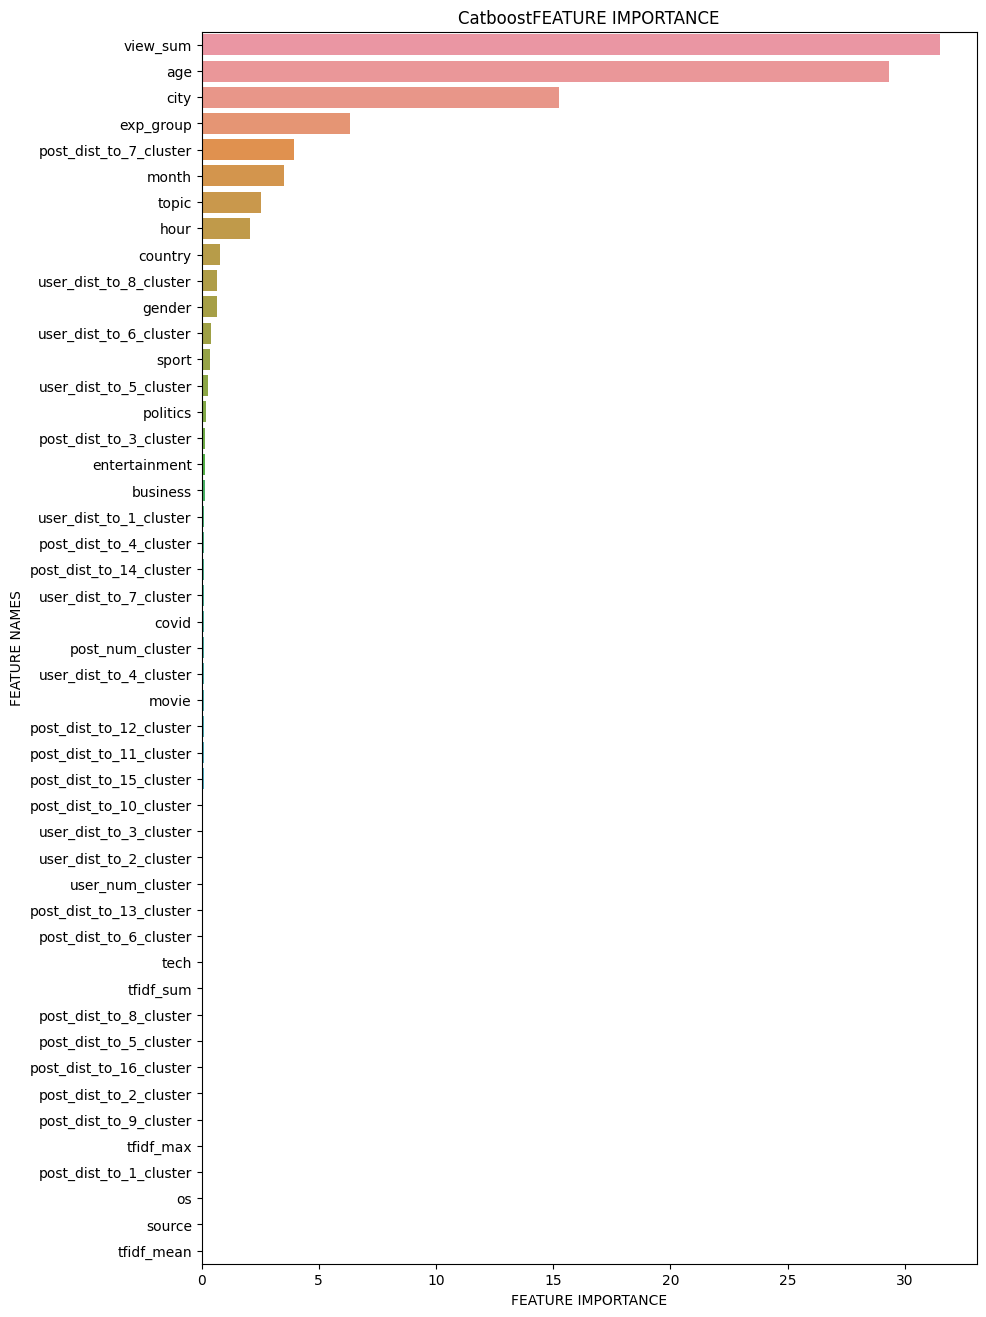

In [ ]:
def plot_feature_importance(importance, names, model_type):

    # Создадим массивы из важности фичей и колонок
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Создадим датафрейм, используя словарь
    data = {'feature_names': feature_names,
            'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Отсортируем датафрейм в убывающем порядке по важности фичей
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10, 16))
    
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost.feature_importances_,
                        X_train.columns, 'Catboost')

In [95]:
# Замерим качества на Кросс-Валидации на 5 фолдах

lgbm_cv = cross_validate(pipe_lgbm, X_train, y_train,
                         scoring="recall",
                         cv=splitter,
                         return_train_score=True)

In [97]:
print(
    f"Среднее recall на тренировочных фолдах: {np.mean(lgbm_cv['train_score']).round(3)}"
)
print(
    f"Среднее recall на тестовых фолдах: {np.mean(lgbm_cv['test_score']).round(3)}"
)

Среднее recall на тренировочных фолдах: 0.804
Среднее recall на тестовых фолдах: 0.783


## Сохранение и загрузка модели

In [96]:
# Сохраним модель LightGBM

filename = 'model_lgbm.pkl'
pickle.dump(pipe_lgbm, open(filename, 'wb'))

In [98]:
# Проверим что все сохранилось правильно

loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict(X_test)

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

## Загрузка фичей на сервер

In [ ]:
# Загрузим фичи юзеров 

user_data.to_sql(
    'maksim_maltsev_users_lesson_22',
    con=conn_url,
    schema='public',
    if_exists='replace',
    index=False
)

205

In [ ]:
# Загрузим фичи постов 

post_text_df.to_sql(
    'maksim_maltsev_posts_lesson_22',
    con=conn_url,
    schema='public',
    if_exists='replace',
    index=False
)

23

In [101]:
# Функция для батчевой загрузки с сервера

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(conn_url)
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [ ]:
# Проверим загрузку фичей юзеров

users_load = batch_load_sql('maksim_maltsev_users_lesson_22')
users_load

,user_id,gender,age,country,city,exp_group,os,source,business,covid,...,tech,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,...,13.0,3.017298,3.578527,2.979593,2.221977,3.635041,3.928811,3.857473,4.662269,3
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,...,29.0,3.889771,6.056264,6.410042,4.467372,2.955178,3.267942,2.681371,3.399628,6
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,...,21.0,3.697253,5.540520,5.193849,3.193716,4.013128,4.113622,1.987895,3.736802,6
3,203,0,18,Russia,Moscow,1,iOS,ads,19.0,71.0,...,9.0,2.231405,2.078781,2.905206,2.956871,4.808711,5.559321,4.258058,5.227635,1
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,8.0,31.0,...,3.0,4.150158,2.145474,2.923159,4.518076,5.788589,7.331909,6.518223,7.071422,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,12.0,83.0,...,12.0,2.236369,2.476267,3.207184,2.973127,3.583664,4.963360,4.091713,4.888445,0
163201,168549,0,18,Russia,Tula,2,Android,organic,14.0,67.0,...,10.0,2.743732,1.837154,2.728837,3.329112,5.176081,6.015830,4.934188,5.767221,1
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,29.0,85.0,...,14.0,3.264920,3.574120,2.974607,2.543692,3.043625,5.191638,4.237303,4.183708,3
163203,168551,0,38,Russia,Moscow,3,iOS,organic,21.0,122.0,...,15.0,2.247021,3.490732,4.051030,3.041200,2.884440,4.402915,3.253753,4.201481,0


In [ ]:
# Проверим загрузку фичей постов

posts_load = batch_load_sql('maksim_maltsev_posts_lesson_22')
posts_load

,post_id,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,...,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster,view_sum
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.000190,0.495805,1.041581,1.017668,1.019208,1.000911,...,1.019183,1.006183,0.983297,1.004058,1.009302,0.919366,1.011768,1.030109,13,8508.0
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.000258,0.308003,1.037858,1.013259,1.015774,0.996825,...,1.014563,1.003411,0.967705,0.999901,1.007325,0.989098,1.011587,1.028142,10,7495.0
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.000276,0.261799,1.040713,1.011287,1.024541,0.997860,...,1.015846,1.005088,0.978229,1.006527,1.006882,0.950109,1.019272,1.027924,13,8412.0
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.000144,0.537713,1.041159,1.017468,1.029216,1.002180,...,1.020306,1.006496,0.977505,1.010382,1.009777,0.992911,1.022562,1.023690,10,8158.0
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.000138,0.420251,1.044158,1.021138,1.031516,1.003333,...,1.023036,1.008690,0.991778,1.020382,1.011292,1.025277,1.028433,1.033378,10,8583.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,6.703302,0.000146,0.258412,1.043225,0.960281,1.029320,0.978045,...,0.995749,1.007191,1.003917,1.024215,0.991503,1.036681,1.020494,1.035921,4,16940.0
7019,7316,I give this movie 2 stars purely because of it...,movie,6.471377,0.000141,0.399419,1.045262,0.977152,1.027771,0.986424,...,0.994587,1.008001,1.007605,1.023026,0.991832,1.035816,1.029342,1.037274,4,6572.0
7020,7317,I cant believe this film was allowed to be mad...,movie,5.628524,0.000122,0.573061,1.045768,0.995772,1.027710,0.991719,...,0.977319,1.008778,1.011118,1.031534,0.993021,1.042517,1.026203,1.036886,8,6803.0
7021,7318,The version I saw of this film was the Blockbu...,movie,6.883375,0.000150,0.231244,1.044712,0.982465,1.013551,0.981802,...,0.975618,1.008061,1.001428,1.023730,0.986877,1.032609,1.016756,1.034422,8,6785.0
